In [28]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, roc_curve, auc, balanced_accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

In [4]:
df = pd.read_csv(r"\Users\malak\OneDrive - Faculty of Computers & Artificial Intelligence\Desktop\nearest-earth-objects(1910-2024).csv")

In [5]:
df.shape

(338199, 9)

In [6]:
df.isna().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338171 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338171 non-null  int64  
 1   name                    338171 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338171 non-null  object 
 6   relative_velocity       338171 non-null  float64
 7   miss_distance           338171 non-null  float64
 8   is_hazardous            338171 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 23.5+ MB


In [9]:
df.duplicated().sum()

0

In [10]:
df = df.drop_duplicates()

In [11]:
df = df.drop(columns=['neo_id', 'name'], errors='ignore')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338171 entries, 0 to 338198
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   absolute_magnitude      338171 non-null  float64
 1   estimated_diameter_min  338171 non-null  float64
 2   estimated_diameter_max  338171 non-null  float64
 3   orbiting_body           338171 non-null  object 
 4   relative_velocity       338171 non-null  float64
 5   miss_distance           338171 non-null  float64
 6   is_hazardous            338171 non-null  bool   
dtypes: bool(1), float64(5), object(1)
memory usage: 18.4+ MB


In [13]:
df['orbiting_body'].unique()

array(['Earth'], dtype=object)

In [14]:
df = df.drop(columns=['orbiting_body'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338171 entries, 0 to 338198
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   absolute_magnitude      338171 non-null  float64
 1   estimated_diameter_min  338171 non-null  float64
 2   estimated_diameter_max  338171 non-null  float64
 3   relative_velocity       338171 non-null  float64
 4   miss_distance           338171 non-null  float64
 5   is_hazardous            338171 non-null  bool   
dtypes: bool(1), float64(5)
memory usage: 15.8 MB


In [16]:
df['is_hazardous'] = df['is_hazardous'].astype(int)

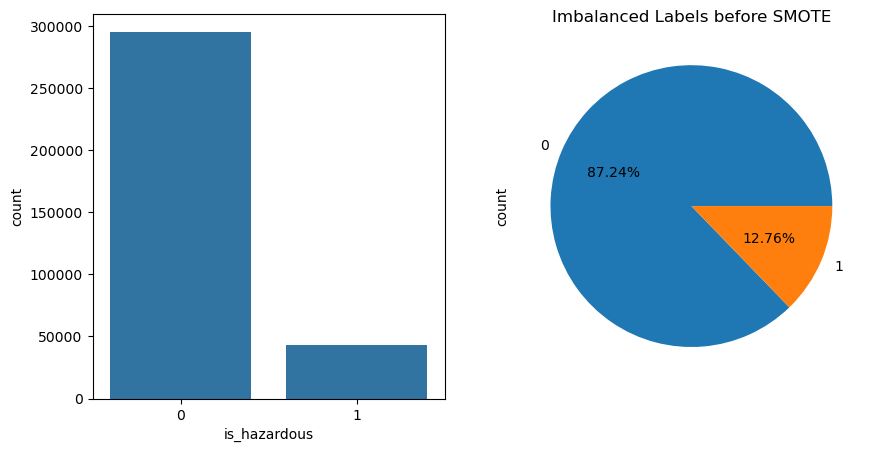

In [17]:
# Visualize the target variable distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=df['is_hazardous'])
plt.subplot(1, 2, 2)
df['is_hazardous'].value_counts().plot(kind='pie', autopct='%0.2f%%')
plt.title('Imbalanced Labels before SMOTE')
plt.show()

In [18]:
# Feature Selection
X = df.drop(['is_hazardous'], axis=1)
y = df['is_hazardous']

In [19]:
# Apply SelectKBest (Only on Numeric Data)
FeatureSelection = SelectKBest(score_func=chi2, k=4)
X_selected = FeatureSelection.fit_transform(X, y)

In [20]:
# Get the selected feature names
selected_features_mask = FeatureSelection.get_support()  # Boolean mask of selected features
selected_feature_names = X.columns[selected_features_mask]  # Names of selected features

print("Selected Features:")
print(selected_feature_names)

Selected Features:
Index(['absolute_magnitude', 'estimated_diameter_max', 'relative_velocity',
       'miss_distance'],
      dtype='object')


In [21]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_selected, y)

New class distribution: Counter({0: 295009, 1: 295009})


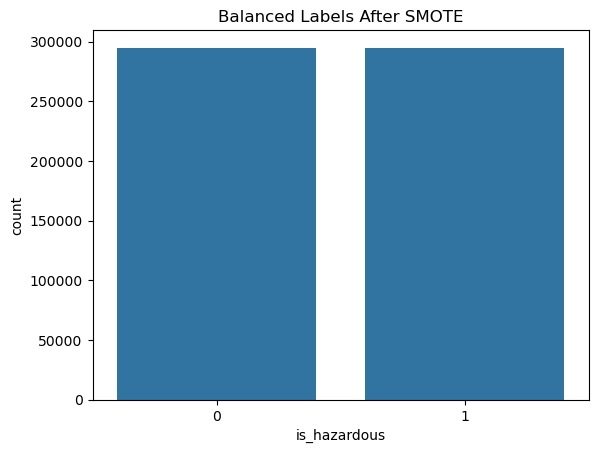

In [22]:
# Display new class distribution
print("New class distribution:", Counter(y_smote))
sns.countplot(x=y_smote)
plt.title('Balanced Labels After SMOTE')
plt.show()

In [23]:
# Scaling the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smote)

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_smote, test_size=0.2, random_state=42)

In [25]:
# Train Final Model
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
# Evaluate the Final Model
y_pred = final_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))

Accuracy: 0.9503152435510661
Precision: 0.9495741402373977
Recall: 0.9510718404450172
F1 Score: 0.9503224002508027
Balanced Accuracy: 0.9503157305206116
MCC: 0.9006316655518358


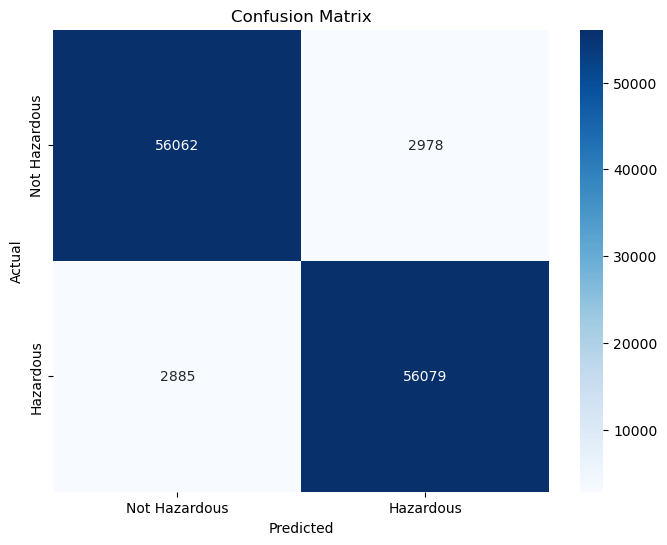

In [29]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hazardous', 'Hazardous'], yticklabels=['Not Hazardous', 'Hazardous'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

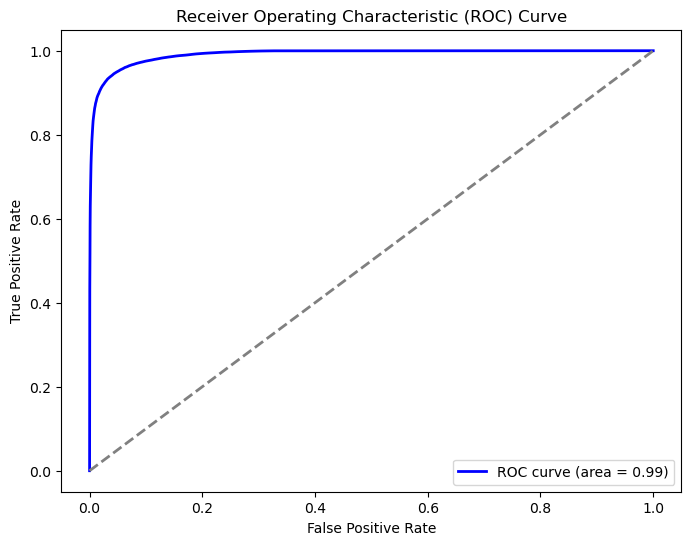

In [31]:
# ROC Curve
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()